# Trabalho prático da disciplina SME0820 - Modelos de Regressão e Aprendizado Supervisionado I 
### Orientador: profº Drº Thomas Kaue Dal´Maso Peron

### Arthur Hiratsuka Rezende - 13687108

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
import statsmodels.api as sm

In [2]:
class Linear_Regression():
    
    def __init__(self, x_init, x_final, number_experiments, n_sample, err_var, intercepto, slope):
        self.n_exp = number_experiments
        self.current_size = -1
        self.sample_size = n_sample
        
        self.lim_inf = x_init
        self.lim_sup = x_final
        
        self.error_variance = err_var
        self.intercepto = intercepto
        self.slope = slope
        
        self.dict_obs = {}
        self.dict_modelo = {}
        self.dict_result = {}
        self.dict_fit = {}

    # Cria observações
    def generate_data(self, sample_size):
        # Modelo real
        eps = np.random.normal(0, self.error_variance**.5, sample_size) # ruido. 
        X = np.linspace(self.lim_inf, self.lim_sup, sample_size) # pontos amostrados
        Y = intercepto + slope*X + eps # valor real de Y
        df_obs = pd.DataFrame()
        df_obs['X_obs'] = X
        df_obs['Y_obs'] = Y
    
        return df_obs
    
    def adjust_model(self, X, Y):
        # Modelo ajustado
        fit = stats.linregress(X,Y)   # ajustando o modelo aos dados.
        x = np.linspace(np.min(X),np.max(X),100) # x para plotar a reta ajustada
        y_model = fit.intercept + fit.slope*x # y para reta ajustada
        df_modelo = pd.DataFrame()
        df_modelo['X_modelo'] = x
        df_modelo['Y_modelo'] = y_model
        df_fit = pd.DataFrame([fit], columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])
        
        return df_modelo, df_fit
    
    def model_std_err(self, exp):
        df_model = self.dict_modelo[self.current_size][exp]

        x_barra = df_model['X_modelo'].mean()

        df_model['sxx'] = ((df_model['X_modelo'] - x_barra)**2)
        Sxx = df_model['sxx'].sum()
        QME = self.dict_result[self.current_size][exp]['QME']
        df_model['erro_padrao'] = (QME[0] * ((1/self.current_size) + (df_model['sxx']/Sxx)))**.5
    
    def compile_stats(self, exp):
        df_exp = self.dict_obs[self.current_size][exp]
        
        df_result = pd.DataFrame(columns=['beta_0', 'beta_1', 'var_b0', 'var_b1', 'QME', 'n_amostra', 'Sxx', 'x_init', 'x_final'])
        
        x_barra = df_exp['X_obs'].mean()
        y_barra = df_exp['Y_obs'].mean()
        
        df_exp['sxy'] = ((df_exp['X_obs'] - x_barra) * (df_exp['Y_obs'] - y_barra))
        df_exp['sxx'] = ((df_exp['X_obs'] - x_barra)**2)
        Sxy = df_exp['sxy'].sum()
        Sxx = df_exp['sxx'].sum()
        
        beta_1 =  Sxy/Sxx
        beta_0 = y_barra - (beta_1*x_barra)
        
        df_exp['Y_modelo'] = df_exp['X_obs']*beta_1 + beta_0
        df_exp['quadradro_residuo'] = (df_exp['Y_obs'] - df_exp['Y_modelo'])**2
        QME = (df_exp['quadradro_residuo'].sum()) / (self.current_size - 2)
        df_exp['erro_padrao'] = (QME * ((1/self.current_size) + (df_exp['sxx']/Sxx)))**.5
        
        var_b0 = QME*((1/self.current_size ) + ((x_barra**2)/Sxx))
        var_b1 = QME/ Sxx
        
        # print(self.error_variance, err_var, self.current_size, x_barra, var_b0, Sxx)
        
        df_result.loc[0] = [beta_0, beta_1, var_b0, var_b1, QME, self.current_size, Sxx, self.lim_inf, self.lim_sup]
        return df_result
    
    def run_experiment(self):
        for sample in self.sample_size:
            self.dict_obs[sample] = {}
            self.dict_modelo[sample] = {}
            self.dict_result[sample] = {}
            self.dict_fit[sample] = {}
            for exp in range(self.n_exp):
                self.current_size = sample
                self.dict_obs[sample][exp] = self.generate_data(sample)
                
                X = self.dict_obs[sample][exp]['X_obs']
                Y = self.dict_obs[sample][exp]['Y_obs']
                self.dict_modelo[sample][exp], self.dict_fit[sample][exp] = self.adjust_model(X = X, Y = Y)
                self.dict_result[sample][exp] = self.compile_stats(exp)
                self.model_std_err(exp)
    
    
    def plot_experiment(self, selected_sample = None):
        
        for sample in self.dict_obs.keys():
            fig = plt.figure(figsize=(11,5))
            fig.suptitle(f"Experimento com amostra de tamanho {sample}",fontsize=20)
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)
            
            
            for exp in self.dict_obs[sample].keys():
    
                x = self.dict_modelo[sample][exp]['X_modelo']
                y_model = self.dict_modelo[sample][exp]['Y_modelo']
                ax2.plot(x,y_model,'-',color='C0',linewidth=0.8,alpha=0.5)
                ax2.set_xlabel(r'$X$',fontsize=16)
                ax2.set_ylabel(r'$Y$',fontsize=16)
            
            ### The true regression line ###    
            xlin = np.linspace(-2+ self.lim_inf,self.lim_sup+2,100) # x data for the theoretical line.
            ytrue = self.intercepto + self.slope*xlin
            
            X = self.dict_obs[sample][self.n_exp - 1]['X_obs']
            Y = self.dict_obs[sample][self.n_exp - 1]['Y_obs']
            
            ### one realization as example ###
            ax1.set_title(r'Uma amostra',fontsize=15)
            ax1.plot(X,Y, 'o',markerfacecolor='white')
            ax1.plot(x,y_model,'-',color='b',linewidth=2,alpha=0.5)
            
            
            # ax1.errorbar(X, Y, yerr=y_error, fmt='o', marker='', label='Barras de erro')
            
            
            ax1.set_xlabel(r'$X$',fontsize=16)
            ax1.set_ylabel(r'$Y$',fontsize=16)
            ax1.plot(xlin,ytrue,'-',color='red',linewidth=1.4,label=r'$Y = 3 + 5X$ (Regressão verdadeira)')
            ax1.plot([],[],'-',color='C0',label=r'$\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X$ (Modelo ajustado)')
            
            ax2.set_title(r'Muitas realizações',fontsize=15)
            ax2.plot(xlin,ytrue,'-',color='red',linewidth=1.4,label=r'$Y = 3 + 5X$ (Regressão verdadeira)')
            ax2.plot([],[],'-',color='C0',label=r'$\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X$ (Modelo ajustado)')
            ax2.legend(loc='lower right',fontsize=14)
            
            delta_axis = 1
            Y = self.dict_obs[sample][self.n_exp - 1]['Y_obs']
            for ax in fig.get_axes():
            
                ax.set_xlim([self.lim_inf-delta_axis,self.lim_sup+delta_axis])
                ax.set_ylim([min(Y)-delta_axis,max(Y)+delta_axis])
                
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                
            plt.tight_layout()    
            plt.show()
            
    def create_report(self, sample_size):
        df_exp = pd.concat(self.dict_result[sample_size], ignore_index=True)
        df_exp['chave'] = df_exp.index
        
        mean_b0 = df_exp['beta_0'].mean()
        mean_b1 = df_exp['beta_1'].mean()
        std_b0 = df_exp['beta_0'].std(ddof = 1)
        std_b1 = df_exp['beta_1'].std(ddof = 1)
        
        var_calc_b0 = df_exp['var_b0'].mean()
        var_calc_b1 = df_exp['var_b1'].mean()
        
        print(f"\nBeta 0:\nValor observado:\t{mean_b0:.3f}\tValor real:\t{float(self.intercepto):.3f}\tDif:\t{100*(1 - (mean_b0/self.intercepto)):.3f}%")
        print(f"Variância obs:\t\t{std_b0**2:.3f}\tValor calc:\t{var_calc_b0:.3f}\tDif:\t{100*(1 - ((std_b0**2)/var_calc_b0)):.3f}%")
        
        print(f"\nBeta 1:\nValor observado:\t{mean_b1:.3f}\tValor real:\t{float(self.slope):.3f}\tDif:\t{100*(1 - (mean_b1/self.slope)):.3f}%")
        print(f"Variância obs:\t\t{std_b1**2:.3f}\tValor calc:\t{var_calc_b1:.3f}\tDif:\t{100*(1 - ((std_b1**2)/var_calc_b1)):.3f}%")
        
    def influencia_amostra(self):
        df = pd.DataFrame(columns=['B_0_barra', 'B_1_barra', 'var_B_0', 'var_B_1', 'n_sample'])
        
        for i, sample_size in enumerate(self.dict_result.keys()):
            df_exp = pd.concat(self.dict_result[sample_size], ignore_index=True)
            mean_b0 = df_exp['beta_0'].mean()
            mean_b1 = df_exp['beta_1'].mean()
            std_b0 = df_exp['beta_0'].std(ddof = 0)
            std_b1 = df_exp['beta_1'].std(ddof = 0)
            df.loc[i] = [mean_b0, mean_b1, std_b0, std_b1, sample_size]
        return df
            
    def full_results(self):
        lista_amostras = []
        for sample_size in self.dict_result.keys():
            df_exp = pd.concat(self.dict_result[sample_size], ignore_index=True)
            lista_amostras.append(df_exp)
        df = pd.concat(lista_amostras, ignore_index=True)
        return df

***
***
***

# Exercício 5
Adota-se o Modelo de Regressão Linear

\begin{equation}
Y = {\beta}_0 + {\beta}_1 X + \varepsilon, \mbox{ with } \varepsilon \sim \mathcal{N}(0,{\sigma}^2)
\end{equation}

## Exercício 5.a
Para a realização do experimento, adota-se os seguintes valores:

- Parâmetro ${\beta}_0 = 3$
- Parâmetro ${\beta}_1 = 5$
- Parâmetro ${\sigma}^2 = 2^2$
- Número de experimentos $N_{exp} = 20$
- Tamanho da amostra $N = 10$
- Limite inferior do intervalo $x_{inf} = 0$
- Limite superior do intervalo $x_{sup} = 10$

A seguir é exibida uma Tabela que relaciona os pontos ${(X_i, Y_i)}$ para os $N$ pontos da amostra. Além disso, confronta-se os valores estimados de $\hat{\beta}_0$  e  $\hat{\beta}_1$, obtidos através do Método dos Mínimos Quadrados (MMQ), e de suas respectivas Variâncias com os valores definidos acima no modelo de regressão, bem como calcula-se a diferença relativa entre os valores observados e os valores calculados.

Os resultados do experimento podem ser visualizados na Figura abaixo, na qual o plot à esquerda demonstra os pontos amostrados e o modelo linear ajustado para esses pontos através do MMQ e o plot à direita exibe todas os experimentos e a reta do modelo idealizado pelo parâmetros acima definidos, destacando a variabilidade dos modelos ajustados em torno da Regressão verdadeira.

Exemplo de tabela com X e Y para os N pontos amostrados:
      X_obs      Y_obs
0  0.000000   4.446543
1  1.111111   8.494903
2  2.222222  13.694185
3  3.333333  16.805521
4  4.444444  25.820357

Beta 0:
Valor observado:	2.860	Valor real:	3.000	Dif:	4.681%
Variância obs:		1.387	Valor calc:	1.176	Dif:	-17.883%

Beta 1:
Valor observado:	4.984	Valor real:	5.000	Dif:	0.321%
Variância obs:		0.042	Valor calc:	0.033	Dif:	-24.555%


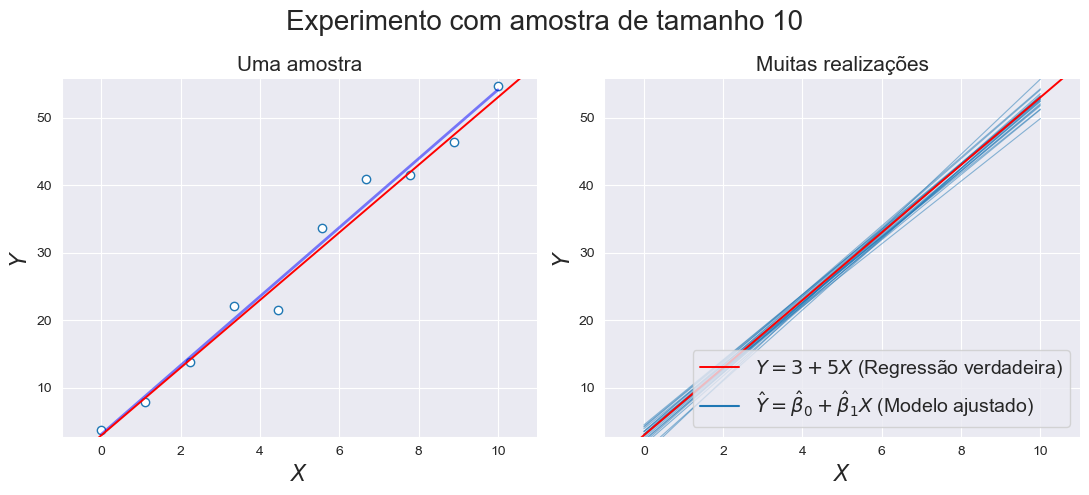

In [3]:
#  EXERCÍCIO 5.a

# Variaveis do experimento
number_experiments = 20
n_sample = [10] # number of samples in each experiment

# Variaveis do modelo
intercepto = 3
slope = 5
err_var = 2**2

# Intervalo observado
x_init = 0
x_final = 10

LR_a = Linear_Regression(x_init, x_final, number_experiments, n_sample, err_var, intercepto, slope)
LR_a.run_experiment()

print("Exemplo de tabela com X e Y para os N pontos amostrados:")
print(LR_a.dict_obs[n_sample[0]][0].iloc[:5,:2])

LR_a.create_report(n_sample[0])

LR_a.plot_experiment()

***
***
***

## Exercício 5.b
Para a realização do experimento, adota-se os seguintes valores:

- Parâmetro ${\beta}_0 = 3$
- Parâmetro ${\beta}_1 = 5$
- Parâmetro ${\sigma}^2 = 2^2$
- Número de experimentos $N_{exp} = 500$
- Tamanho da amostra $N = [10, 25, 50, 100, 150,250, 500, 1000, 3000, 4000, 5000, 6500, 8000, 10000]$
- Limite inferior do intervalo $x_{inf} = 0$
- Limite superior do intervalo $x_{sup} = 50$

C:\Users\arthu\AppData\Local\Temp\ipykernel_5312\1262123848.py:40: FutureWarning: 

The `scale` parameter has been renamed to `width_method` and will be removed in v0.15. Pass `width_method='linear' for the same effect.
  sns.boxenplot(x="n_amostra", y="beta_0",
C:\Users\arthu\AppData\Local\Temp\ipykernel_5312\1262123848.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\arthu\AppData\Local\Temp\ipykernel_5312\1262123848.py:59: FutureWarning: 

The `scale` parameter has been renamed to `width_method` and will be removed in v0.15. Pass `width_method='linear' for the same effect.
  sns.boxenplot(x="n_amostra", y="beta_1",
C:\Users\arthu\AppData\Local\Temp\ipykernel_5312\1262123848.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


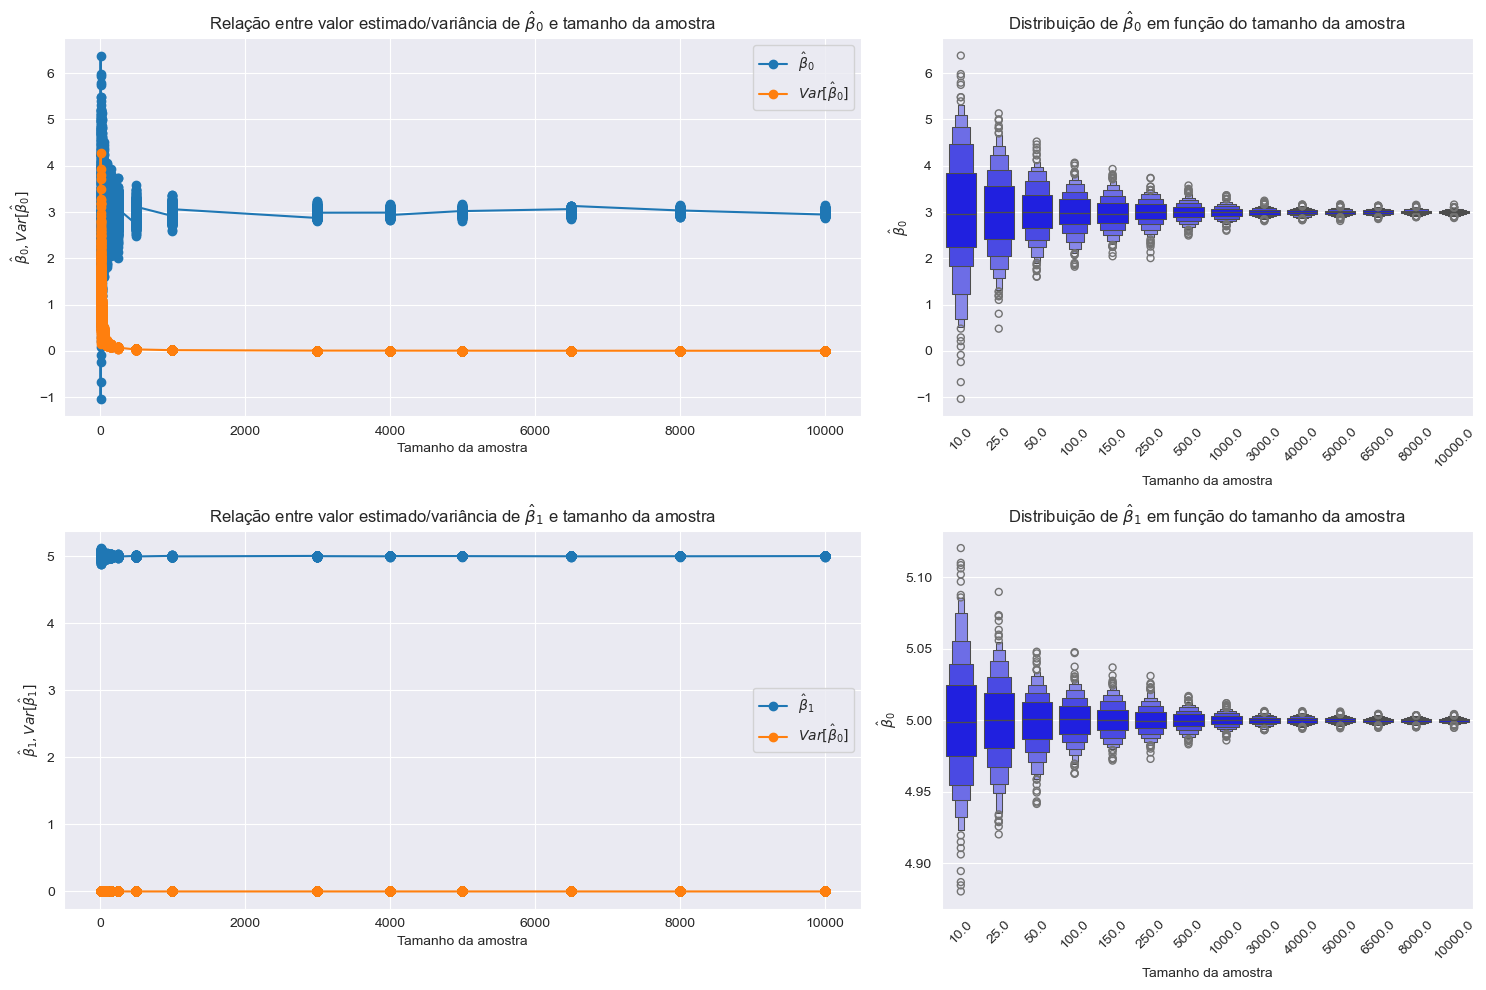

In [4]:
#  EXERCÍCIO 5.b

# Variaveis do experimento
number_experiments = 500
n_sample = [10, 25, 50, 100, 150,250, 500, 1000, 3000, 4000, 5000, 6500, 8000, 10000] # number of samples in each experiment

# Variaveis do modelo
intercepto = 3
slope = 5
err_var = 2**2

# Intervalo observado
x_init = 0
x_final = 50

LR_b = Linear_Regression(x_init, x_final, number_experiments, n_sample, err_var, intercepto, slope)
LR_b.run_experiment()

df_full = LR_b.full_results()

fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [3, 2]})

# Variáveis a serem plotadas no eixo y
variaveis_b0 = ['beta_0', 'var_b0']
variaveis_b1 = ['beta_1', 'var_b1']
label = {'beta_0' : r'$\hat{\beta}_0$', 'beta_1' : r'$\hat{\beta}_1$', 'var_b0' : r'$Var[\hat{\beta}_0]$', 'var_b1' : r'$Var[\hat{\beta}_0]$'}



ax = axs[0][0]
for variavel in variaveis_b0:
    ax.plot(df_full['n_amostra'], df_full[variavel], marker='o', label=label[variavel])

ax.set_title(r'Relação entre valor estimado/variância de $\hat{\beta}_0$ e tamanho da amostra')
ax.set_xlabel('Tamanho da amostra')
ax.set_ylabel(r'$\hat{\beta}_0, Var[\hat{\beta}_0]$')
ax.legend()

ax = axs[0][1]
sns.boxenplot(x="n_amostra", y="beta_0",
              color="b",
              scale="linear", data=df_full, ax=ax);

ax.set_title(r'Distribuição de $\hat{\beta}_0$ em função do tamanho da amostra')
ax.set_xlabel('Tamanho da amostra')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(r'$\hat{\beta}_0$')

ax = axs[1][0]
for variavel in variaveis_b1:
    ax.plot(df_full['n_amostra'], df_full[variavel], marker='o', label=label[variavel])

ax.set_title(r'Relação entre valor estimado/variância de $\hat{\beta}_1$ e tamanho da amostra')
ax.set_xlabel('Tamanho da amostra')
ax.set_ylabel(r'$\hat{\beta}_1, Var[\hat{\beta}_1]$')
ax.legend()

ax = axs[1][1]
sns.boxenplot(x="n_amostra", y="beta_1",
              color="b",
              scale="linear",
            data=df_full, ax=ax);

ax.set_title(r'Distribuição de $\hat{\beta}_1$ em função do tamanho da amostra')
ax.set_xlabel('Tamanho da amostra')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(r'$\hat{\beta}_0$')


# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()

Na Figura acima os plots à esquerda explicitam o comportamento do valor esperado do parâmetro $\hat{\beta}_i$ e de sua variância conforme ocorre o aumento do tamanho da amostra. Observa-se que em ambos os casos (tanto para $\hat{\beta}_0$ na primeira linha quanto para $\hat{\beta}_1$ na segunda linha), ocorre a convergência dos valores esperados para os valores "verdadeiros" e a variância dos parâmetros tende à zero para amostras de tamanho suficientemente elevado. 

Já nos plots à direita é possível observar, para amostras de tamanho 10, que o parâmetro $\hat{\beta}_0$ tem uma variabilidade grande quando comparado com o valor adotado ${\beta}_0 = 3$, com intervalo aproximado de $[-0.60, 6.50]$, enquanto o parâmetro $\hat{\beta}_1$ não exibe valores tão extremos quando comparado com o valor adotado ${\beta}_1 = 5$, apresentando um intervalo aproximado de $[4.90, 5.10]$. 

A partir desse resultado calcula-se, para experimentos cujo tamanho de amostra é igual a 10, o desvio padrão do parâmetro $\hat{\beta}_0$ como sendo $\hat{\sigma}_0 = 1.21$ e o desvio padrão do parâmetro $\hat{\beta}_1$ como sendo $\hat{\sigma}_1 = 0.04$. Portanto, para amostras de tamanho reduzido, conclui-se que o intervalo de valores observados dos parâmetros pode ser aproximado como $[{\beta}_i - 3*\hat{\sigma}_i, {\beta}_i + 3*\hat{\sigma}_i]$.



Tomando amostras suficientemente grandes, os valores de ambos parâmetros convergem para os valores adotados como verdadeiros e apresentam reduzida variabilidade, explicitando o efeito favorável, se tratando da acurácia da estimação de parâmetros, de aumentar o tamanho da amostra nos experimentos.


<br>
<br>

***
***
***

## Exercício 5.c
Para a realização do experimento, adota-se os seguintes valores:

- Parâmetro ${\beta}_0 = 3$
- Parâmetro ${\beta}_1 = 5$
- Parâmetro ${\sigma}^2 = 75^2$
- Número de experimentos $N_{exp} = 10$
- Tamanho da amostra $N = 20$
- Limite inferior do intervalo $x_{inf} = 10$
- Limite superior do intervalo $x_{sup} = 25$

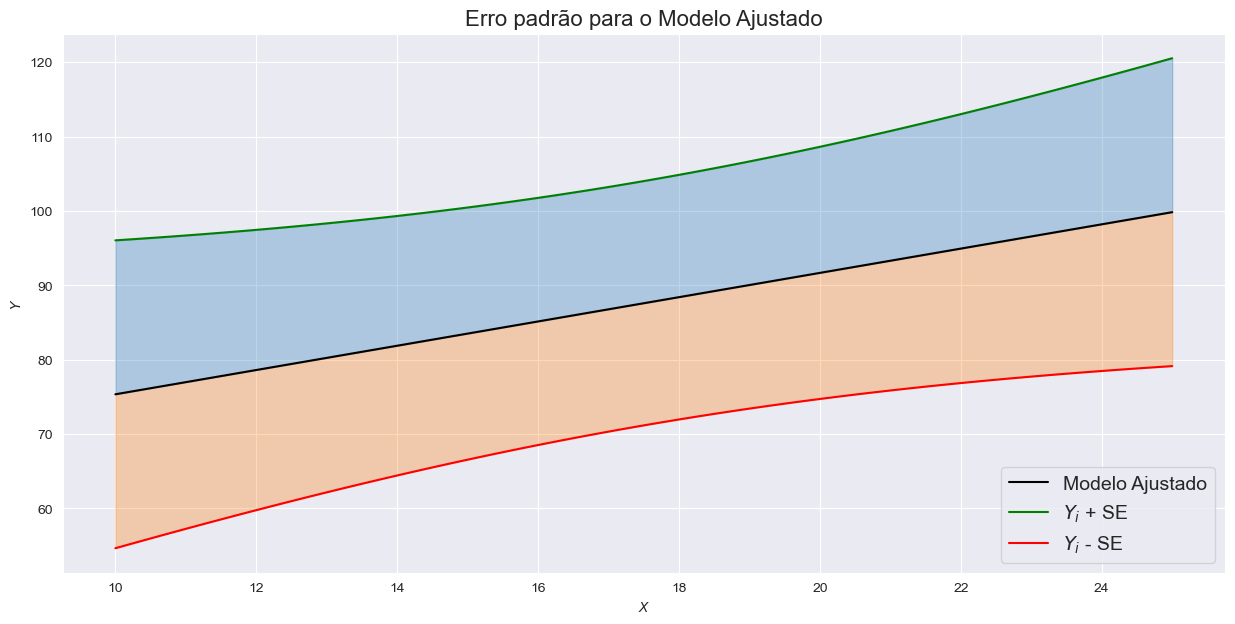

In [5]:
#  EXERCÍCIO 5.c

# Variaveis do experimento
number_experiments = 10
n_sample = [20] # number of samples in each experiment

# Variaveis do modelo
intercepto = 3
slope = 5
err_var = 75**2

# Intervalo observado
x_init = 10
x_final = 25

LR_c = Linear_Regression(x_init, x_final, number_experiments, n_sample, err_var, intercepto, slope)
LR_c.run_experiment()

df_std_err = LR_c.dict_modelo[n_sample[0]][0][['X_modelo', 'Y_modelo', 'erro_padrao']].copy()
df_std_err['margem_sup'] = df_std_err['Y_modelo'] + df_std_err['erro_padrao']
df_std_err['margem_inf'] = df_std_err['Y_modelo'] - df_std_err['erro_padrao']

x = df_std_err['X_modelo']
y = df_std_err['Y_modelo']
y1 = df_std_err['margem_inf']
y2 = df_std_err['margem_sup']

x_obs = LR_c.dict_obs[n_sample[0]][0]['X_obs']
y_obs = LR_c.dict_obs[n_sample[0]][0]['Y_obs']

fig, ax = plt.subplots(1, 1, figsize=(15,7))
# sns.lineplot(data=df_range, x='Sxx', y='var_b0', color='red', linewidth=2, ls='-.', ,ax=ax)
ax.set_title('Erro padrão para o Modelo Ajustado', fontsize=16)
ax.plot(x, y, color='black', label="Modelo Ajustado")
# ax.plot(x_obs,y_obs,color='black', linewidth=0, marker='o',markerfacecolor='white')

ax.plot(x, y2, color='green', label=r"$Y_i$ + SE")
ax.plot(x, y1, color='red', label=r"$Y_i$ - SE")


ax.fill_between(x, y, y1, where=(y > y1), color='C1', alpha=0.3)
ax.fill_between(x, y, y2, where=(y < y2), color='C0', alpha=0.3)

ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.legend(loc='lower right',fontsize=14);

In [6]:
LR_c.dict_obs[20][0]

,X_obs,Y_obs,sxy,sxx,Y_modelo,quadradro_residuo,erro_padrao
0,10.000000,33.748904,403.804529,56.250000,75.342182,1730.000782,31.663197
1,10.789474,126.668655,-262.241648,45.031163,76.631374,2503.729508,29.264932
2,11.578947,31.222637,333.751207,35.058864,77.920566,2180.696576,26.954594
3,12.368421,141.323059,-275.737962,26.333102,79.209759,3858.062147,24.756814
4,13.157895,220.306074,-576.269299,18.853878,80.498951,19546.031623,22.704302
5,13.947368,131.333494,-155.406265,12.621191,81.788143,2454.741766,20.840022
6,14.736842,-14.146693,281.113187,7.635042,83.077335,9452.511706,19.218832
7,15.526316,102.524112,-29.476192,3.895429,84.366527,329.697868,17.906876
8,16.315789,22.470720,77.114354,1.402355,85.655720,3992.344146,16.976004
9,17.105263,63.506697,9.506373,0.155817,86.944912,549.349914,16.490874


Na Figura acima é possível observar a variação do Erro Padrão (SE) ao longo da reta obtida através do modelo ajustado. Tal variação é explicada observando a equação da variância do modelo ajustado e a relação entre variância e Erro Padrão:

\begin{equation}
VAR[\hat m(x)] = {\sigma}^2 * [\frac{1}{N} + \frac{(x - \bar x)^2}{S_{xx}}]
\end{equation}

\begin{equation}
SE = VAR[\hat m(x)] ^ \frac{1}{2}
\end{equation}

Onde:
- ${\sigma}^2$ é a variância do erro ($\varepsilon \sim \mathcal{N}(0,{\sigma}^2)$);
- $N$ é o tamanho da amostra;
- $S_{xx} = \sum \limits _{i=1} ^{N} (x_{i} - \bar x)^2 $

Uma vez que a variância do erro ($\sigma^2$), tamanho da amostra ($N$) e $S_{xx}$ são constantes para todos os pontos, o erro padrão SE passa a depender exclusivamente do quadrado da distância entre o ponto observado e a média ($(x - \bar x)^2$), de forma que pontos mais afastados da média tem maior erro padrão e o ponto sobre a média tem o menor erro padrão.


<br>
<br>

***
***
***

## Exercício 5.d
Para a realização do experimento, adota-se os seguintes valores:

- Parâmetro ${\beta}_0 = 3$
- Parâmetro ${\beta}_1 = 5$
- Parâmetro ${\sigma}^2 = 2^2$
- Número de experimentos $N_{exp} = 20$
- Tamanho da amostra $N = 20$
- Limite inferior do intervalo $x_{inf} = 0 $(parte I) e $50$ (parte II)
- Limite superior do intervalo $x_{sup} = 200$

Obs. Varia-se o range do intervalo com passo de 10 unidades.

In [7]:
def create_range(range_size, xi = 0):
    xf = xi + range_size
    return xf

def plot_exp(range_init = 0):
    # Variaveis do experimento
    number_experiments = 20
    n_sample = [20] # number of samples in each experiment
    
    # Variaveis do modelo
    intercepto = 3
    slope = 5
    err_var = 2**2
    
    # Intervalo observado
    x_init = range_init
    
    lista_amostras = []
    lista_betas = []
    
    for exp in range(number_experiments):
        for i in range(10, 210, 10):
            x_final = create_range(i, x_init)
            LR_d = Linear_Regression(x_init, x_final, number_experiments, n_sample, err_var, intercepto, slope)
            LR_d.run_experiment()

            lista_betas.append(LR_d.dict_result[n_sample[0]][0][['beta_0', 'beta_1', 'Sxx']])
            lista_amostras.append(LR_d.dict_result[n_sample[0]][0])
    
    df_range = pd.concat(lista_amostras, ignore_index=True)
    df_betas = pd.concat(lista_betas, ignore_index=True)
    
    var_b0 = []
    var_b1 = []
    
    for sxx in df_betas['Sxx'].unique():
        var_b0.append((df_betas[df_betas['Sxx'] == sxx]['beta_0'].std(ddof = 1))**2)
        var_b1.append((df_betas[df_betas['Sxx'] == sxx]['beta_1'].std(ddof = 1))**2)
        
    fig, axs = plt.subplots(1, 2, figsize=(25, 4)) 
    fig.suptitle(r"Experimento com range iniciando em $X_{inf} = $" + str(x_init), fontsize=16)

    
    ax = axs[0]
    sns.lineplot(data=df_range, x='Sxx', y='var_b0', color='red', linewidth=2, ls='-.', label=r'$\hat{\beta}_0$ - Calculado',ax=ax)
    sns.lineplot(x=df_range['Sxx'].unique(), y=var_b0, color='red', linewidth=2, label=r'${\beta}_0$ - Dados',ax=ax)
    
    sns.lineplot(data=df_range, x='Sxx', y='var_b1', color='blue', linewidth=2, ls='-.', label=r'$\hat{\beta}_1$ - Calculado',ax=ax)
    sns.lineplot(x=df_range['Sxx'].unique(), y=var_b1, color='blue', linewidth=2, label=r'${\beta}_1$ - Dados',ax=ax)
    
    ax.set_xlabel(r'$S_{xx}$')
    ax.set_ylabel(r'$Var[{\beta}_i]$')
    ax.set_title(r'Relação entre $Var[{\beta}_i]$ e $S_{xx}$')
    
    ax = axs[1]
    sns.lineplot(data=df_range, x='Sxx', y='var_b0', color='red', linewidth=2, ls='-.', label=r'$\hat{\beta}_0$ - Calculado',ax=ax)
    sns.lineplot(x=df_range['Sxx'].unique(), y=var_b0, color='red', linewidth=2, label=r'${\beta}_0$ - Dados',ax=ax)

    sns.lineplot(data=df_range, x='Sxx', y='var_b1', color='blue', linewidth=2, ls='-.', label=r'$\hat{\beta}_1$ - Calculado',ax=ax)
    sns.lineplot(x=df_range['Sxx'].unique(), y=var_b1, color='blue', linewidth=2, label=r'${\beta}_1$ - Dados',ax=ax)

    ax.set_xlabel(r'$S_{xx}$')
    ax.set_ylabel(r'$Var[{\beta}_i]$')
    ax.set_title(r'Relação entre $Var[\hat {\beta}_i]$ e $S_{xx}$ - Escala Logarítmica')
    plt.xscale('log')
    plt.yscale('log')
    
    plt.show()

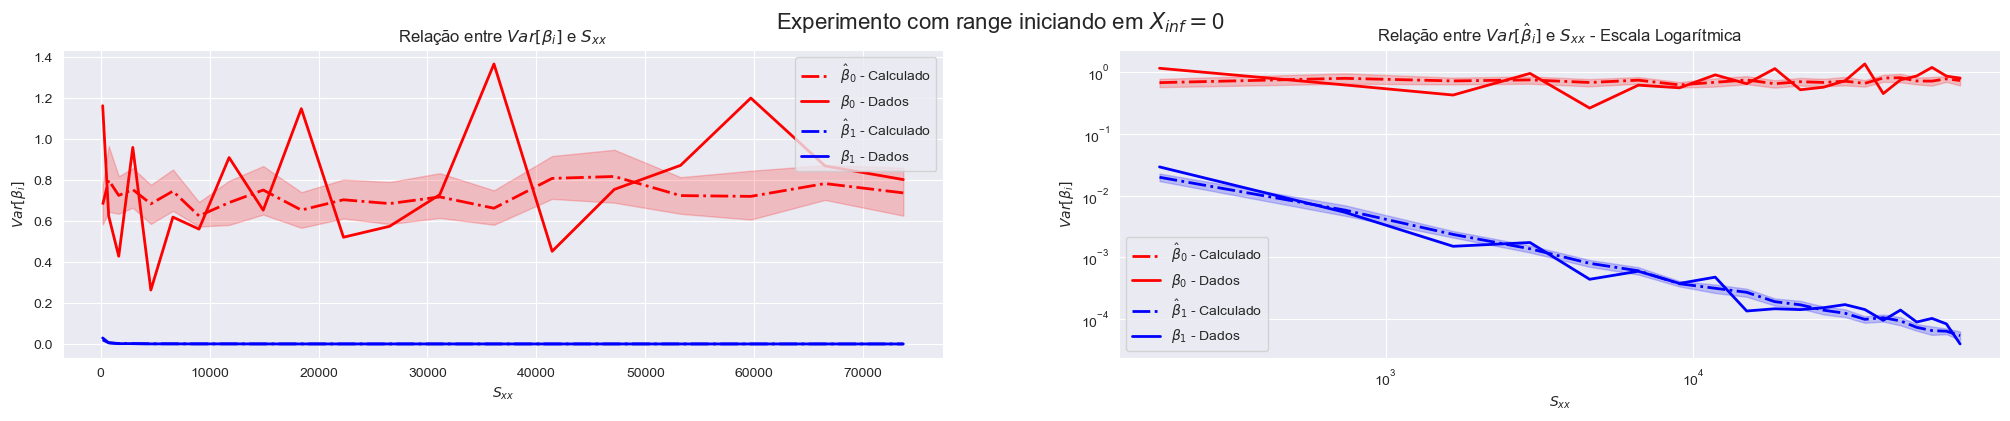

In [8]:
plot_exp(0)

Em um primeiro momento é feito o experimento com o range partindo de $X_1 = 0$, variando de 10 em 10 unidades até $X_n = 200$. É possível observar, no gráfico à esquerda, que a variância $Var[\hat {\beta}_1]$ tem valores baixos não importando o $S_{xx}$ resultante da variação do tamanho do range e com os valores calculados e observados guardando elevada semelhança.
 
Já $Var[\hat {\beta}_0]$ apresenta certa flutuação em torno do valor calculado, porém observando o plot em escala logarítmica à direita, é possível observar que existe forte correlação entre os valores calculado e observados de variância dos parâmetros $\hat {\beta}_i$, conforme varia-se o valor de $S_{xx}$, bem como os valores calculado e observado são quase coincidentes.

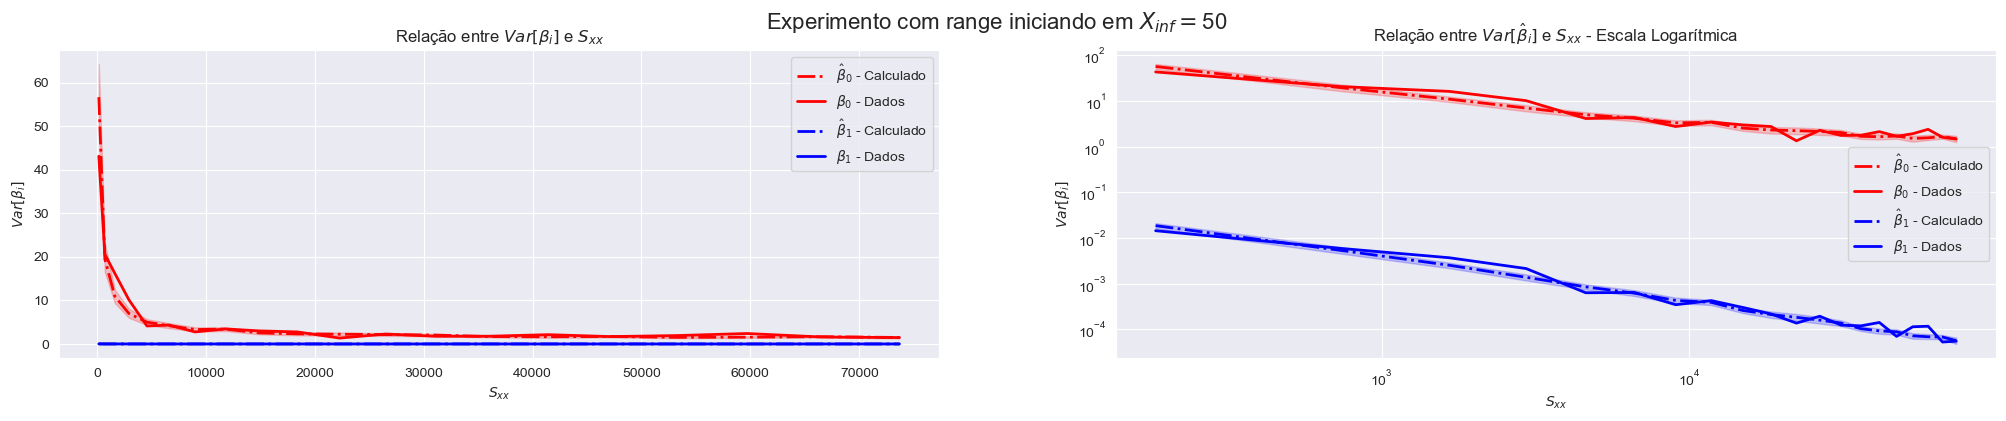

In [9]:
plot_exp(50)

Variando o experimento, adotando-se o valor inicail do range como $X_1 = 0$, nota-se que a variância $Var[\hat {\beta}_0]$ passa a ter valores bem mais elevados no início do experimento, explicitando a diferença provocada no intercepto quando inicia-se uma Regressão Linear em valores distantes da origem.

Porém, com o aumento do intervalo essa variação fica próxima ao observado no primeiro caso, evidenciando que intervalos de amostragem pequenos, cujo valor de $\hat {\beta}_0$ sejam altos podem levar à uma variabilidade grande para esse parâmetro, de forma que a observação desse cenário deve ser tratada com devidos cuidados na modelagem com Regressão Linear.